# Data Ingestion Pipeline

### Loading npy(s)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
processed_dataset  = "processed_data"

In [3]:
from scipy.ndimage import zoom
import os

# numero di sample richiesti
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []
anchors            = []

for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    anchor             = jnp.array(np.load("%s/anchors/anchor_%d.npy"                       % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(zoom(voxelization,(1./2.,1./2.,1./2.)))
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    anchors.append(anchor)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
30 su 301
60 su 301
90 su 301
120 su 301
150 su 301
180 su 301
210 su 301
240 su 301
270 su 301
300 su 301


# Train Test Split

In [4]:
indici_train = np.arange(len(voxelizations)) < int(len(voxelizations) * .8)
indici_test  = ~indici_train         

# Batch extraction

In [5]:
def extract_dataset(N = 150,window_size = 8):
    X_train,F_train,Y_train = [],[],[]
    X_test ,F_test ,Y_test  = [],[],[]
     
    selezionati_train = np.random.choice(
                            np.arange(
                                len(indici_train)
                            ) , size = N
                        )
    selezionati_test = np.random.choice(
                            np.arange(
                                len(indici_train)
                            ) , size = N
                        )
    ##### TRAIN
    for sample in selezionati_train:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_train.append( curr_vox[ 
                            (i+window_size) - window_size: (i+window_size) + window_size,
                            (j+window_size) - window_size: (j+window_size) + window_size,
                            (k+window_size) - window_size: (k+window_size) + window_size
                          ] )
        F_train.append(finger_prints[sample])
        Y_train.append( np.sum((center  - centers_of_mass[sample])**2) )
    
    
    #### TEST
    for sample in selezionati_test:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_test.append( curr_vox[ 
                            (i+window_size) - window_size: (i+window_size) + window_size,
                            (j+window_size) - window_size: (j+window_size) + window_size,
                            (k+window_size) - window_size: (k+window_size) + window_size
                          ] )
        F_test.append(finger_prints[sample])
        Y_test.append( np.sum((center  - centers_of_mass[sample])**2) )        
        
    return (jnp.array(X_train),jnp.array(F_train),jnp.array(Y_train)), (jnp.array(X_test),jnp.array(F_test),jnp.array(Y_test))

# Reward

In [16]:
def corr(x,y):
    return ((x - x.mean())@(y - y.mean()))/(jnp.linalg.norm(x - x.mean())*jnp.linalg.norm(y - y.mean()))
def reward(W,Wf,X,F,Y):
    Y_hat = jax.vmap(lambda x: (x*W).sum())(X) + jax.vmap(lambda f: (f*Wf).sum())(F)
    return corr(Y_hat,Y)
reward = jax.jit(reward)
grad   = jax.jit(jax.grad(reward))

# Computational Loop

L'idea é quella di utilizzare una <b> ascesa del gradiente stocastica </b> per massimizzare la correlazione tra l'output del modello e la distanza al quadrato tra il <b> punto che rappresenta il centro della voxelgrid selezionata e il punto effettivo di attachment del ligando </b>.
Il modello prende in ingresso 
1. la subvoxelgrid centrata nel punto di cui si vuole valutare la bontá
2. la finger print del ligando
I parametri $\theta$ sono rappresentati da un tensore ${\bf W}$ che agisce come un funzionale lineare nello spazio delle subvoxelgrid di ordine $n$ e un vettore ${\bf W_f}$ che agisce invece come funzionale nello spazio delle fingerprint

In [62]:
%matplotlib qt5

In [63]:
window = 10               # grandezza della finestra
np.random.seed(123)       # fisso il seed per la riproducibilitá 
W      = np.random.normal(size = (2*window,2*window,2*window))
Wf     = np.random.normal(size = 2048)
plt.figure()

# dati del grafico

validation_scores = []

# ciclo di calcolo

for i in range(2000):
    (X_train_curr, F_train_curr,Y_train_curr) , (X_test_curr, F_test_curr,Y_test_curr) = extract_dataset(window_size=window)
    W += 1e-1 * grad(W,Wf,X_train_curr,F_train_curr,Y_train_curr)
    print( i, reward(W,Wf,X_train_curr,F_train_curr,Y_train_curr), reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)  )
   
    validation_score = reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)
    validation_scores.append(validation_score)
    
    plt.scatter(i, validation_score, s = 50., color = 'black')
    if i % 10 == 0:
        plt.show()
        plt.pause(1e-12)

0 -0.17356884 -0.23516802
1 -0.12486593 -0.21679145
2 -0.04053097 -0.21972871
3 -0.28261137 0.008554468
4 -0.17994241 -0.22636904
5 -0.20646906 -0.17419241
6 -0.3041256 -0.014794546
7 -0.23440617 -0.1960509
8 -0.09850448 -0.18840489
9 -0.22061785 0.0375865
10 -0.18506032 -0.08677919
11 -0.08060044 -0.04476686
12 -0.10577873 -0.095210046
13 -0.20281507 -0.047065698
14 -0.216717 -0.218735
15 -0.12842369 -0.08362241
16 -0.08465644 -0.17109028
17 -0.19436473 -0.023905091
18 -0.21915291 -0.20804273
19 -0.29624397 -0.10633293
20 -0.17014147 -0.08522787
21 -0.30249014 -0.085023254
22 -0.049425453 -0.05000796
23 -0.24628286 -0.037123803
24 -0.14801456 -0.055727378
25 -0.14683412 -0.15239327
26 -0.07990543 -0.059407968
27 -0.052412268 -0.06633304
28 0.0064421813 -0.06983417
29 0.0106049385 0.018903704
30 -0.07547695 -0.23260997
31 -0.06300429 -0.15530364
32 -0.23823562 -0.03719192
33 -0.1551883 -0.10890337
34 -0.094368145 -0.17879488
35 -0.07771843 -0.056210615
36 -0.25251588 -0.0641718
37 -0.1

300 0.22835745 0.25423625
301 0.22020797 0.029971663
302 0.14750566 0.18320695
303 0.13899122 0.22558588
304 0.053563125 0.30592167
305 0.069435276 0.051861335
306 0.03206273 0.14776441
307 0.093684524 0.023227764
308 0.21029411 0.25448465
309 0.21397805 0.3021316
310 -0.03774338 0.15371037
311 0.22523698 0.2069057
312 0.08922457 0.2044748
313 0.10621863 0.20138304
314 0.1465432 0.2921973
315 0.22673397 0.1266294
316 0.17220545 0.10180521
317 0.17191263 0.2375922
318 0.25974047 0.3267107
319 0.12491416 0.2572326
320 0.13637927 0.23140475
321 0.13283487 0.17961164
322 0.081475 0.047350816
323 0.15868492 0.23971781
324 0.095396586 0.105831146
325 0.1793901 0.13962354
326 0.1764498 0.047094874
327 0.30473006 0.11269498
328 0.10142834 0.06363634
329 0.07870125 0.22293831
330 0.19011226 0.12286553
331 0.1447138 0.18945794
332 0.12415172 0.19855946
333 0.1165443 0.2472255
334 -0.0344819 0.2703766
335 0.20587882 0.21077468
336 0.12574086 0.15332685
337 0.21638191 0.16819975
338 0.087541945 0.

621 0.18958375 0.34157574
622 0.35464814 0.28267473
623 0.19332395 0.25392637
624 0.23779355 0.36812592
625 0.25668505 0.29546058
626 0.35204113 0.4429855
627 0.20069791 0.33660403
628 0.383639 0.26865476
629 0.29316482 0.21519558
630 0.18998453 0.43585423
631 0.366369 0.33776623
632 0.32000035 0.3548386
633 0.3309293 0.27443716
634 0.35424393 0.22384967
635 0.2481592 0.31864852
636 0.12143215 0.26173607
637 0.17186776 0.17919649
638 0.28570375 0.14752185
639 0.3865233 0.31591228
640 0.34471837 0.374622
641 0.27289015 0.35441896
642 0.3194886 0.39729866
643 0.28779793 0.25397938
644 0.27951017 0.40318274
645 0.22207496 0.389879
646 0.3135293 0.3917388
647 0.3793776 0.3073313
648 0.38633206 0.30201948
649 0.27522102 0.22621945
650 0.46131855 0.27086115
651 0.32507795 0.28698105
652 0.33157358 0.34825006
653 0.31381333 0.4281198
654 0.33536515 0.323095
655 0.33968872 0.26578966
656 0.30034012 0.28707296
657 0.3410969 0.36738798
658 0.44838718 0.3434381
659 0.18296883 0.2937337
660 0.4291

945 0.34378386 0.4249345
946 0.3260731 0.35502222
947 0.31185272 0.39617425
948 0.347902 0.50307137
949 0.46870062 0.41906714
950 0.40437672 0.32579392
951 0.39751723 0.3605178
952 0.36794937 0.4115305
953 0.3253083 0.42923206
954 0.44355872 0.4766774
955 0.3813287 0.41150978
956 0.278283 0.36764312
957 0.42569968 0.44673583
958 0.5334871 0.29355735
959 0.4394508 0.42912224
960 0.39935294 0.4757665
961 0.27583677 0.38237798
962 0.29071847 0.4405435
963 0.37283036 0.40917513
964 0.41720092 0.41808248
965 0.33156738 0.43071592
966 0.38227725 0.5181668
967 0.38680312 0.3431834
968 0.44631654 0.4223602
969 0.34853622 0.50133103
970 0.31972966 0.32106796
971 0.22725503 0.33669758
972 0.42834473 0.40505537
973 0.35438615 0.3851906
974 0.3016216 0.35529003
975 0.30190608 0.40000156
976 0.3082622 0.47688663
977 0.31835854 0.43432066
978 0.35527515 0.360125
979 0.42048123 0.35163102
980 0.3684465 0.4048715
981 0.32406622 0.3760858
982 0.43158787 0.47902733
983 0.35362145 0.42299256
984 0.315012

1259 0.3778718 0.42373922
1260 0.37959808 0.39121035
1261 0.33603454 0.46046096
1262 0.4593951 0.4523197
1263 0.35613787 0.4080918
1264 0.47018683 0.3353892
1265 0.2930968 0.5247962
1266 0.4489811 0.42847323
1267 0.39906922 0.4012112
1268 0.5365958 0.38215578
1269 0.41669717 0.36269113
1270 0.48084 0.397459
1271 0.41921973 0.5189259
1272 0.47542182 0.49997333
1273 0.2851687 0.5396504
1274 0.42354497 0.48303574
1275 0.40989378 0.5121334
1276 0.3663351 0.48358315
1277 0.44749185 0.50429064
1278 0.4344564 0.37395644
1279 0.34554467 0.50569403
1280 0.42914516 0.40231034
1281 0.50686044 0.45338935
1282 0.34242052 0.5572292
1283 0.44441512 0.45282328
1284 0.37477443 0.5156722
1285 0.38601506 0.5172411
1286 0.4233139 0.39070722
1287 0.41313815 0.35391963
1288 0.43238366 0.43336946
1289 0.48961076 0.4275604
1290 0.24671285 0.5447043
1291 0.4676576 0.49156004
1292 0.30917683 0.48209602
1293 0.4965418 0.3922774
1294 0.46675408 0.5252394
1295 0.4461275 0.5291738
1296 0.36964318 0.50296396
1297 0.

1572 0.37024355 0.5279847
1573 0.46185622 0.47584414
1574 0.4149452 0.4250493
1575 0.44451272 0.4606997
1576 0.33127165 0.48394695
1577 0.38209915 0.46536687
1578 0.33657113 0.47466838
1579 0.40317753 0.33067197
1580 0.50591534 0.4824558
1581 0.4008956 0.4167716
1582 0.4890831 0.47817218
1583 0.44031483 0.38570166
1584 0.44628134 0.52111346
1585 0.5116379 0.4818416
1586 0.4946326 0.48644873
1587 0.45995137 0.45330584
1588 0.44108683 0.47345135
1589 0.4599104 0.4971669
1590 0.46886995 0.4631154
1591 0.44268894 0.4573169
1592 0.3422497 0.40610874
1593 0.4363732 0.43353802
1594 0.47161028 0.48635677
1595 0.4445046 0.49782214
1596 0.5322744 0.5057992
1597 0.44192412 0.47012624
1598 0.5281385 0.42267773
1599 0.43407583 0.42956403
1600 0.5269288 0.49438357
1601 0.38755175 0.4290776
1602 0.4348286 0.49686742
1603 0.47890753 0.43917626
1604 0.39381135 0.53942347
1605 0.39997065 0.43929568
1606 0.49282393 0.5024844
1607 0.41439444 0.44410864
1608 0.37583393 0.4256868
1609 0.42803195 0.35658523


1886 0.5575068 0.520204
1887 0.47258723 0.5121259
1888 0.4332922 0.516897
1889 0.34819427 0.50599736
1890 0.3889697 0.50672126
1891 0.41684508 0.5003068
1892 0.56943774 0.49591887
1893 0.43877807 0.40186176
1894 0.49013346 0.5242368
1895 0.46824417 0.5952069
1896 0.293601 0.5443143
1897 0.49939346 0.44818357
1898 0.58422464 0.5479944
1899 0.46123892 0.526215
1900 0.6075723 0.4650815
1901 0.4294851 0.49182954
1902 0.4830441 0.4387282
1903 0.4981702 0.4492636
1904 0.5226437 0.46288535
1905 0.46755838 0.5971473
1906 0.49538195 0.49364683
1907 0.46278283 0.46182978
1908 0.36253187 0.50448114
1909 0.31275597 0.46017855
1910 0.45527288 0.4397406
1911 0.4345779 0.5283143
1912 0.53981495 0.4920384
1913 0.38269594 0.5125588
1914 0.46612835 0.54527485
1915 0.43296883 0.5457411
1916 0.44380578 0.4502395
1917 0.5483497 0.48969686
1918 0.51392424 0.52528614
1919 0.40995786 0.5589399
1920 0.49190626 0.38715833
1921 0.47866562 0.49789423
1922 0.49320775 0.511802
1923 0.5071268 0.55931294
1924 0.49151

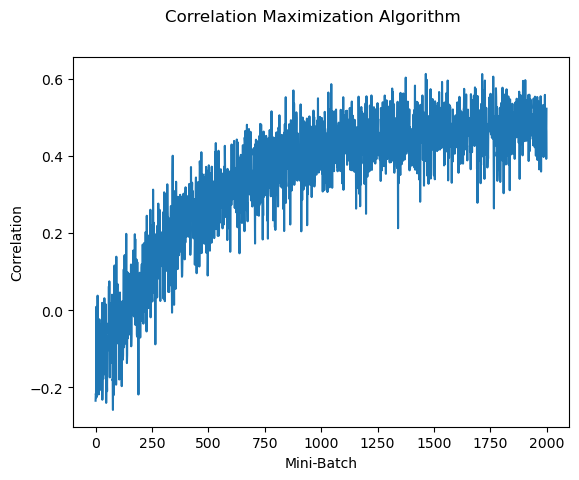

In [64]:
%matplotlib inline
plt.suptitle("Correlation Maximization Algorithm")
plt.ylabel("Correlation")
plt.xlabel("Mini-Batch")
plt.plot(validation_scores)

# Test

Data una voxelizzazione carico gli anchor point e ne calcolo la distanza con il punto di attachment.
Per testare la bontá del classificatore precedente viene analizzata la correlazione tra l'output e la distanza effettiva

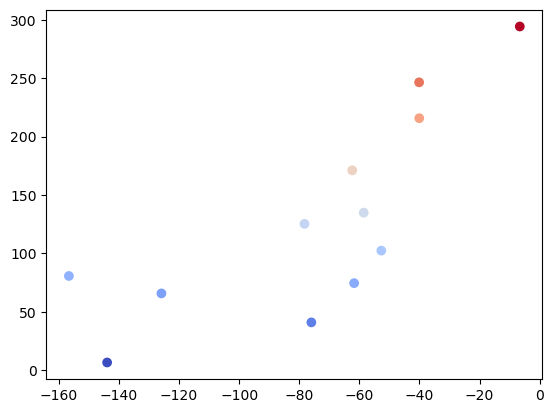

In [97]:
sample = np.arange(len(voxelizations))[indici_test][34]

# costrusico la voxgrid paddata

Nx,Ny,Nz  = voxelizations[sample].shape
curr_vox  = jnp.pad(
                voxelizations[sample],
                pad_width = (
                    (window,window),
                    (window,window),
                    (window,window)
                )
            )

points = []
for a in anchors[sample]:
    correct_distance = jnp.sum( ( a - centers_of_mass[sample] )**2 )
    
    # trovo il voxel associato al punto di ancoraggip
    x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs[sample]
    x,y,z = a
    i,j,k = (
             int( (x - x_min)/(x_max - x_min) * Nx ),
             int( (y - y_min)/(y_max - y_min) * Ny ),
             int( (z - z_min)/(z_max - z_min) * Nz )
    )

    # estraggo la subvoxelgrid
    subvox = curr_vox[ 
                            (i+window) - window: (i+window) + window,
                            (j+window) - window: (j+window) + window,
                            (k+window) - window: (k+window) + window
                          ]
    # estraggo il farmaco
    f      = finger_prints[sample]
    Y_hat = (subvox*W).sum() + f @ Wf
    
    points.append([Y_hat,correct_distance])

points = np.array(points)
plt.scatter(points[:,0],points[:,1],c = points[:,1], cmap = 'coolwarm')

Si osservi come l'output del calssificatore sia effettivamente in grado di "correlare" con la distanza effettiva (punti vicini al punto di ancoraggio producono un output piccolo)